In [1]:
import tensorflow as tf
import os
import numpy as np 
import matplotlib.pyplot as plt
# from tensorflow.keras.layers import Conv2D
# import cv2 as cv

In [2]:
# from zipfile import ZipFile
  
# with ZipFile("C:/Users/Timii/Documents/Dev_Materials/DATASETS/FER-2013.zip", 'r') as zObject:
#     zObject.extractall(
#         path="C:/Users/Timii/Documents/Dev/Zummit/fer_data")

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

train_dir = "C:/Users/Timii/Documents/Dev/Zummit/fer_data/train"
test_dir = "C:/Users/Timii/Documents/Dev/Zummit/fer_data/test"


train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, batch_size=BATCH_SIZE,
                                                             image_size=IMG_SIZE, label_mode='categorical')

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,  batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE, label_mode='categorical')

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [4]:
class_names = train_dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

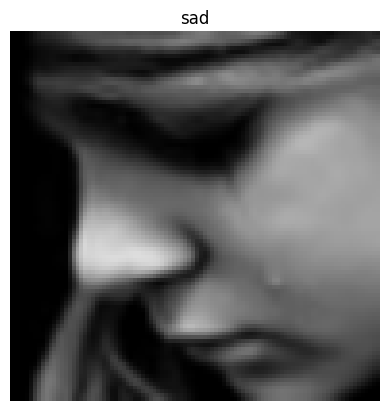

In [5]:
idx=9
for img, label in train_dataset.take(1):
    plt.imshow(img[idx].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label[idx])])
    plt.axis("off")
    break

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmenter = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2, 0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
]) 

In [8]:
help(tf.keras.applications)

Help on package keras.api._v2.keras.applications in keras.api._v2.keras:

NAME
    keras.api._v2.keras.applications - Keras Applications are premade architectures with pre-trained weights.

PACKAGE CONTENTS
    convnext (package)
    densenet (package)
    efficientnet (package)
    efficientnet_v2 (package)
    imagenet_utils (package)
    inception_resnet_v2 (package)
    inception_v3 (package)
    mobilenet (package)
    mobilenet_v2 (package)
    mobilenet_v3 (package)
    nasnet (package)
    regnet (package)
    resnet (package)
    resnet50 (package)
    resnet_rs (package)
    resnet_v2 (package)
    vgg16 (package)
    vgg19 (package)
    xception (package)

FILE
    c:\users\timii\documents\dev\.aienv\lib\site-packages\keras\api\_v2\keras\applications\__init__.py




In [9]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE+(3,)),
                                                   include_top=False, 
                                                   weights='imagenet')

base_model.trainable = False 

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


OSError: Unable to open file (truncated file: eof = 139918, sblock->base_addr = 0, stored_eof = 9406464)

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE+(3,))) 
x = data_augmenter(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.003
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 5
history = model.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)

In [ ]:
base_model = model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function=tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.1*base_learning_rate)
metrics= ['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)              


In [ ]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss += history_fine.history['loss']
# val_loss += history_fine.history['val_loss']

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0, 1])
# plt.plot([initial_epochs-1,initial_epochs-1],
#           plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
# plt.plot([initial_epochs-1,initial_epochs-1],
#          plt.ylim(), label='Start Fine Tuning')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')
# plt.show()